In [31]:
# P/glade/ core
from typing import Optional, Callable, TypedDict, Union, Iterable, Tuple, NamedTuple, List
from dataclasses import dataclass
import datetime
from itertools import product
from concurrent import futures

# Scientific python
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import pytorch_lightning as pl


In [2]:
ZARR = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/TOTAL_2013-01-01_2013-12-31_staged.zarr/'

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.interpolation'] = 'none'

torch.cuda.is_available()

/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


False

In [3]:
def get_forward_data(filename: str=ZARR) -> xr.DataArray:
    """Lazily opens the Zarr store on gladefilesystem.
    """
    dataset = xr.open_zarr(filename, consolidated=True)
    return dataset

In [4]:
def get_forward_data(filename) -> xr.DataArray:
    """Lazily opens the Zarr store on gladefilesystem.
    """
    dataset = xr.open_zarr(filename, consolidated=True)
    return dataset


In [93]:
Array = Union[np.ndarray, xr.DataArray]
IMAGE_ATTR_NAMES = ('historical_ERA5_images', 'target_ERA5_images')

class Sample(TypedDict):
    """Simple class for structuring data for the ML model.
    
    Using typing.TypedDict gives us several advantages:
      1. Single 'source of truth' for the type and documentation of each example.
      2. A static type checker can check the types are correct.

    Instead of TypedDict, we could use typing.NamedTuple,
    which would provide runtime checks, but the deal-breaker with Tuples is that they're immutable
    so we cannot change the values in the transforms.
    """
    # IMAGES
    # Shape: batch_size, seq_length, lat, lon, lev
    historical_ERA5_images: Array
    target_ERA5_images: Array
        
    # METADATA
    datetime_index: Array



def flatten_list(list_of_lists):
    """
    Flatten a list of lists.

    Parameters:
    - list_of_lists (list): A list containing sublists.

    Returns:
    - flattened_list (list): A flattened list containing all elements from sublists.
    """
    return [item for sublist in list_of_lists for item in sublist]

def generate_integer_list_around(number, spacing=10):
    """
    Generate a list of integers on either side of a given number with a specified spacing.

    Parameters:
    - number (int): The central number around which the list is generated.
    - spacing (int): The spacing between consecutive integers in the list. Default is 10.

    Returns:
    - integer_list (list): List of integers on either side of the given number.
    """
    lower_limit = number - spacing
    upper_limit = number + spacing + 1  # Adding 1 to include the upper limit
    integer_list = list(range(lower_limit, upper_limit))

    return integer_list

def find_key_for_number(input_number, data_dict):
    """
    Find the key in the dictionary based on the given number.

    Parameters:
    - input_number (int): The number to search for in the dictionary.
    - data_dict (dict): The dictionary with keys and corresponding value lists.

    Returns:
    - key_found (str): The key in the dictionary where the input number falls within the specified range.
    """
    for key, value_list in data_dict.items():
        if value_list[1] <= input_number <= value_list[2]:
            return key

    # Return None if the number is not within any range
    return None


class NormalizeState():
    def __init__(self,mean_file,std_file):
        self.mean_ds = xr.open_dataset(mean_file)
        self.std_ds = xr.open_dataset(std_file)

    def __call__(self, sample:Sample)->Sample:
        normalized_sample = {}
        for key, value in sample.items():
            if isinstance(value, xr.Dataset):
                #key_change = key
                #value_change = (value - self.mean_ds)/self.std_ds
                #sample[key]=value_change
                normalized_sample[key] = (value - self.mean_ds) / self.std_ds
        return normalized_sample


class NormalizeTendency:
    def __init__(self, variables, surface_variables, base_path):
        self.variables = variables
        self.surface_variables = surface_variables
        self.base_path = base_path

        # Load the NetCDF files and store the data
        self.mean = {}
        self.std = {}
        for name in self.variables + self.surface_variables:
            mean_dataset = nc.Dataset(f'{self.base_path}/All_NORMtend_{name}_2010_staged.mean.nc')
            std_dataset = nc.Dataset(f'{self.base_path}/All_NORMtend_{name}_2010_staged.STD.nc')
            self.mean[name] = torch.from_numpy(mean_dataset.variables[name][:])
            self.std[name] = torch.from_numpy(std_dataset.variables[name][:])

    def transform(self, tensor, surface_tensor):
        device = tensor.device

        # Apply z-score normalization using the pre-loaded mean and std
        for name in self.variables:
            mean = self.mean[name].view(1, 1, self.mean[name].size(0), 1, 1).to(device)
            std = self.std[name].view(1, 1, self.std[name].size(0), 1, 1).to(device)
            transformed_tensor = (tensor - mean) / std

        for name in self.surface_variables:
            mean = self.mean[name].view(1, 1, 1, 1).to(device)
            std = self.std[name].view(1, 1, 1, 1).to(device)
            transformed_surface_tensor = (surface_tensor - mean) / std

        return transformed_tensor, transformed_surface_tensor

    def inverse_transform(self, tensor, surface_tensor):
        device = tensor.device

        # Reverse z-score normalization using the pre-loaded mean and std
        for name in self.variables:
            mean = self.mean[name].view(1, 1, self.mean[name].size(0), 1, 1).to(device)
            std = self.std[name].view(1, 1, self.std[name].size(0), 1, 1).to(device)
            transformed_tensor = tensor * std + mean

        for name in self.surface_variables:
            mean = self.mean[name].view(1, 1, 1, 1).to(device)
            std = self.std[name].view(1, 1, 1, 1).to(device)
            transformed_surface_tensor = surface_tensor * std + mean

        return transformed_tensor, transformed_surface_tensor

    
class ToTensor():
    def __init__(self,hist_len=int(1),for_len=int(2)):
        
        self.hist_len = hist_len
        self.for_len = for_len
        self.allvarsdo = ['U','V','T','Q','SP','t2m','V500','U500','T500','Z500','Q500']
        self.surfvars = ['SP', 't2m','V500','U500','T500','Z500','Q500']
        
    def __call__(self, sample: Sample) -> Sample:
    
        return_dict = {}
        if (self.hist_len==1) & (self.for_len ==2):
            for key, value in sample.items():

                if isinstance(value, xr.DataArray):
                    value_var = value.values

                elif isinstance(value, xr.Dataset):
                    surface_vars = []
                    concatenated_vars = []
                    for vv in self.allvarsdo: 
                        value_var = value[vv].values
                        if vv in self.surfvars:
                            surface_vars_temp = value_var
                            surface_vars.append(surface_vars_temp)
                        else:
                            concatenated_vars.append(value_var)

                else: 
                    value_var = value        

                if key == 'historical_ERA5_images':
                    return_dict['x_surf'] = torch.as_tensor(surface_vars).squeeze()
                    return_dict['x'] = torch.as_tensor(np.vstack(concatenated_vars))
                elif key == 'target_ERA5_images':
                    y_surf = torch.as_tensor(surface_vars)
                    #print(y_surf)
                    y = torch.as_tensor(np.hstack([np.expand_dims(x, axis=1) for x in concatenated_vars]))
                    return_dict['y1_surf'] = y_surf[:,0]
                    return_dict['y2_surf'] = y_surf[:,1]
                    return_dict['y1'] = y[0]
                    return_dict['y2'] = y[1]
                    
        else:
            for key, value in sample.items():

                if isinstance(value, xr.DataArray):
                    value_var = value.values

                elif isinstance(value, xr.Dataset):
                    surface_vars = []
                    concatenated_vars = []
                    for vv in self.allvarsdo: 
                        value_var = value[vv].values
                        if vv in self.surfvars:
                            surface_vars_temp = value_var
                            surface_vars.append(surface_vars_temp)
                        else:
                            concatenated_vars.append(value_var)

                else: 
                    value_var = value        

                if key == 'historical_ERA5_images':
                    return_dict['x_surf'] = torch.as_tensor(surface_vars).squeeze()
                    return_dict['x'] = torch.as_tensor(np.hstack([np.expand_dims(x, axis=1) for x in concatenated_vars]))
                elif key == 'target_ERA5_images':
                    y_surf = torch.as_tensor(surface_vars)
                    #print(y_surf)
                    y = torch.as_tensor(np.hstack([np.expand_dims(x, axis=1) for x in concatenated_vars]))
                    # y = torch.as_tensor(np.vstack(concatenated_vars))
                    return_dict['y_surf'] = y_surf
                    return_dict['y'] = y
                    
                
        return return_dict 
    

class ERA5Dataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        filenames: list = ['/glade/derecho/scratch/wchapman/STAGING/TOTAL_2012-01-01_2012-12-31_staged.zarr','/glade/derecho/scratch/wchapman/STAGING/TOTAL_2013-01-01_2013-12-31_staged.zarr'],
        history_len: int = 1,
        forecast_len: int = 2,
        transform: Optional[Callable] = None,
        SEED=42,
        skip_periods=None,
    ):
        self.history_len = history_len
        self.forecast_len = forecast_len
        self.transform = transform
        self.skip_periods = skip_periods
        self.total_seq_len = self.history_len + self.forecast_len
        all_fils = []
        filenames = sorted(filenames)
        for fn in filenames:
            all_fils.append(get_forward_data(filename=fn))
        self.all_fils = all_fils
        self.data_array = all_fils[0]
        self.rng = np.random.default_rng(seed=SEED)
        
        #set data places: 
        indo = 0
        self.meta_data_dict = {}
        for ee,bb in enumerate(self.all_fils):
            self.meta_data_dict[str(ee)]=[len(bb['time']),indo,indo+len(bb['time'])]
            indo += len(bb['time'])+1
            
        #set out of bounds indexes... 
        OOB = []
        for kk in self.meta_data_dict.keys():
            OOB.append(generate_integer_list_around(self.meta_data_dict[kk][2]))
        self.OOB = flatten_list(OOB)
                
    def __post_init__(self):
        #: Total sequence length of each sample.
        self.total_seq_len = self.history_len + self.forecast_len

    def __len__(self):
        tlen = 0
        for bb in self.all_fils:
            tlen+=len(bb['time']) - self.total_seq_len + 1
        return tlen

    def __getitem__(self, index):
        
        #find the result key:
        result_key = find_key_for_number(index, self.meta_data_dict)
        #get the data selection:
        true_ind = index-self.meta_data_dict[result_key][1] 
        
        if true_ind > (len(self.all_fils[int(result_key)]['time'])-(self.history_len+self.forecast_len+1)):
            true_ind = len(self.all_fils[int(result_key)]['time'])-(self.history_len+self.forecast_len+1)
       
        datasel = self.all_fils[int(result_key)].isel(time=slice(true_ind, true_ind+self.history_len+self.forecast_len+1)).load()
        
        print(datasel['time'])
        
        
        if self.skip_periods is not None:
            sample = Sample(
                historical_ERA5_images=datasel.isel(time=slice(0, self.history_len,self.skip_periods)),
                target_ERA5_images=datasel.isel(time=slice(self.history_len, len(datasel['time']),self.skip_periods)),
                datetime_index=datasel.time.values.astype('datetime64[s]').astype(int)
            )
        else:
            sample = Sample(
                historical_ERA5_images=datasel.isel(time=slice(0, self.history_len)),
                target_ERA5_images=datasel.isel(time=slice(self.history_len, len(datasel['time']))),
                datetime_index=datasel.time.values.astype('datetime64[s]').astype(int)
            )

        if self.transform:
            sample = self.transform(sample)
        return sample
    
    


In [94]:
import glob
FNS = sorted(glob.glob('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/TOTAL_*'))

## This is the new call John Schreck!!! , its a little hacky with having to define hist_len and for_len twice...

If you want to keep it how you used to do it (and it will return what you are used to): 

history_len,hist_len = 1 

forecast_len,for_len = 2

skip_periods=None


if you want to skip periods (i.e. every other hour, every six hours .. etc.), there is a skip_periods flag.

In [99]:
nunu=17

Dataset= ERA5Dataset(filenames=[FNS[nunu]],history_len=14,forecast_len=15,skip_periods=2)
print(FNS[nunu])
BB = Dataset.__getitem__(8784)

/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/TOTAL_2000-01-01_2000-12-31_staged.zarr
<xarray.DataArray 'time' (time: 30)>
array(['2000-12-30T18:00:00.000000000', '2000-12-30T19:00:00.000000000',
       '2000-12-30T20:00:00.000000000', '2000-12-30T21:00:00.000000000',
       '2000-12-30T22:00:00.000000000', '2000-12-30T23:00:00.000000000',
       '2000-12-31T00:00:00.000000000', '2000-12-31T01:00:00.000000000',
       '2000-12-31T02:00:00.000000000', '2000-12-31T03:00:00.000000000',
       '2000-12-31T04:00:00.000000000', '2000-12-31T05:00:00.000000000',
       '2000-12-31T06:00:00.000000000', '2000-12-31T07:00:00.000000000',
       '2000-12-31T08:00:00.000000000', '2000-12-31T09:00:00.000000000',
       '2000-12-31T10:00:00.000000000', '2000-12-31T11:00:00.000000000',
       '2000-12-31T12:00:00.000000000', '2000-12-31T13:00:00.000000000',
       '2000-12-31T14:00:00.000000000', '2000-12-31T15:00:00.000000000',
       '2000-12-31T16:00:00.000000000', '2000-12-31T17:00:00.000000000'

## With ToTensor:

In [90]:
Dataset= ERA5Dataset(filenames=[FNS[nunu]],transform=transforms.Compose([ToTensor(hist_len=14,for_len=15)]),history_len=14,forecast_len=15,skip_periods=2)
print(FNS[nunu])
BB = Dataset.__getitem__(8784)

/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/TOTAL_2000-01-01_2000-12-31_staged.zarr
<xarray.DataArray 'time' (time: 30)>
array(['2000-12-30T18:00:00.000000000', '2000-12-30T19:00:00.000000000',
       '2000-12-30T20:00:00.000000000', '2000-12-30T21:00:00.000000000',
       '2000-12-30T22:00:00.000000000', '2000-12-30T23:00:00.000000000',
       '2000-12-31T00:00:00.000000000', '2000-12-31T01:00:00.000000000',
       '2000-12-31T02:00:00.000000000', '2000-12-31T03:00:00.000000000',
       '2000-12-31T04:00:00.000000000', '2000-12-31T05:00:00.000000000',
       '2000-12-31T06:00:00.000000000', '2000-12-31T07:00:00.000000000',
       '2000-12-31T08:00:00.000000000', '2000-12-31T09:00:00.000000000',
       '2000-12-31T10:00:00.000000000', '2000-12-31T11:00:00.000000000',
       '2000-12-31T12:00:00.000000000', '2000-12-31T13:00:00.000000000',
       '2000-12-31T14:00:00.000000000', '2000-12-31T15:00:00.000000000',
       '2000-12-31T16:00:00.000000000', '2000-12-31T17:00:00.000000000'

NameError: name 'skip_periods' is not defined

In [ ]:
BB['y'].shape

In [ ]:
nunu=17
Dataset= ERA5Dataset(filenames=[FNS[nunu]],history_len=3,forecast_len=5)
print(FNS[nunu])
Dataset.__getitem__(10)['target_ERA5_images']

In [117]:
Dataset= ERA5Dataset(filenames=FNS[1:])

...merging...


In [118]:
Dataset.__getitem__(10)

{'historical_ERA5_images': <xarray.Dataset>
 Dimensions:     (time: 1, level: 15, latitude: 640, longitude: 1280,
                  half_level: 138)
 Coordinates:
   * half_level  (half_level) int32 1 2 3 4 5 6 7 ... 132 133 134 135 136 137 138
   * latitude    (latitude) float64 89.78 89.51 89.23 ... -89.23 -89.51 -89.78
   * level       (level) int32 10 30 40 50 60 70 80 90 95 100 105 110 120 130 136
   * longitude   (longitude) float64 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
   * time        (time) datetime64[ns] 2012-01-01T10:00:00
 Data variables:
     Q           (time, level, latitude, longitude) float32 4.004e-06 ... 0.00...
     Q500        (time, latitude, longitude) float32 2.343e-05 ... 0.0001925
     SP          (time, latitude, longitude) float32 9.991e+04 ... 6.945e+04
     T           (time, level, latitude, longitude) float32 247.1 247.1 ... 247.2
     T500        (time, latitude, longitude) float32 230.4 230.4 ... 234.2 234.2
     U           (time, level, latitude, l

In [101]:
(23000-17546)

5454

In [99]:
23000-(26306-17546)

14240

In [98]:
13000-(17545-8785)

4240

In [87]:
Dataset.meta_data_dict

{'0': [8784, 0, 8784], '1': [8760, 8785, 17545], '2': [8760, 17546, 26306]}

In [80]:
Dataset.meta_data_dict

{'0': [8784, 0, 8784], '1': [8760, 8785, 17545], '2': [8760, 17546, 26306]}

In [91]:
def find_key_for_number(input_number, data_dict):
    """
    Find the key in the dictionary based on the given number.

    Parameters:
    - input_number (int): The number to search for in the dictionary.
    - data_dict (dict): The dictionary with keys and corresponding value lists.

    Returns:
    - key_found (str): The key in the dictionary where the input number falls within the specified range.
    """
    for key, value_list in data_dict.items():
        if value_list[1] <= input_number <= value_list[2]:
            return key

    # Return None if the number is not within any range
    return None

# Your dictionary
your_dict = {'0': [8784, 0, 8784], '1': [8760, 8785, 17545], '2': [8760, 17546, 26306]}

# Example usage:
input_number = 10
result_key = find_key_for_number(input_number, your_dict)

print(result_key)

0


In [64]:
Dataset.__len__()

26298

In [6]:
DS = get_forward_data('/glade/derecho/scratch/wchapman/STAGING/TOTAL_2010-01-01_2010-12-31_staged.zarr/')

In [49]:
Dataset.all_fils[1]

<xarray.Dataset>
Dimensions:     (time: 8760, level: 15, latitude: 640, longitude: 1280,
                 half_level: 138)
Coordinates:
  * half_level  (half_level) int32 1 2 3 4 5 6 7 ... 132 133 134 135 136 137 138
  * latitude    (latitude) float64 89.78 89.51 89.23 ... -89.23 -89.51 -89.78
  * level       (level) int32 10 30 40 50 60 70 80 90 95 100 105 110 120 130 136
  * longitude   (longitude) float64 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
  * time        (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    Q           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
    Q500        (time, latitude, longitude) float32 dask.array<chunksize=(10, 640, 1280), meta=np.ndarray>
    SP          (time, latitude, longitude) float32 dask.array<chunksize=(10, 320, 640), meta=np.ndarray>
    T           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
    T500        (time, latitude, longitude) float32 dask.array<chunksize=(10, 640, 1280), meta=np.ndarray>
    U           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
    U500        (time, latitude, longitude) float32 dask.array<chunksize=(10, 640, 1280), meta=np.ndarray>
    V           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
    V500        (time, latitude, longitude) float32 dask.array<chunksize=(10, 640, 1280), meta=np.ndarray>
    Z500        (time, latitude, longitude) float32 dask.array<chunksize=(10, 640, 1280), meta=np.ndarray>
    t2m         (time, latitude, longitude) float32 dask.array<chunksize=(10, 139, 277), meta=np.ndarray>

## Grab the Data from loader
This could be a problem.... we might need to chunk it so that time is the only delinearter. 

In [5]:
%%time
forcing_data = get_forward_data().unify_chunks()

#this could be a problem!: 
zarr_chunk_boundaries = np.concatenate(([0], np.cumsum(forcing_data.chunks['time'])))

CPU times: user 2.53 s, sys: 208 ms, total: 2.74 s
Wall time: 6.09 s


## Transforming classes

In [6]:
Array = Union[np.ndarray, xr.DataArray]
IMAGE_ATTR_NAMES = ('historical_ERA5_images', 'target_ERA5_images')
class Sample(TypedDict):
    """Simple class for structuring data for the ML model.
    
    Using typing.TypedDict gives us several advantages:
      1. Single 'source of truth' for the type and documentation of each example.
      2. A static type checker can check the types are correct.

    Instead of TypedDict, we could use typing.NamedTuple,
    which would provide runtime checks, but the deal-breaker with Tuples is that they're immutable
    so we cannot change the values in the transforms.
    """
    # IMAGES
    # Shape: batch_size, seq_length, lat, lon, lev
    historical_ERA5_images: Array
    target_ERA5_images: Array
        
    # METADATA
    datetime_index: Array


In [7]:
@dataclass
class Reshape_Data():
    size: int = 128  #: Size of the cropped image.

    def __call__(self, sample: Sample) -> Sample:
        crop_params = None
        for attr_name in IMAGE_ATTR_NAMES:
            image = sample[attr_name]
            # TODO: Random crop!
            cropped_image = image[..., :self.size, :self.size]
            sample[attr_name] = cropped_image
        return sample


class CheckForBadData():
    def __call__(self, sample: Sample) -> Sample:
        for attr_name in IMAGE_ATTR_NAMES:
            image = sample[attr_name]
            if np.any(image < 0):
                raise BadData(f'\n{attr_name} has negative values at {image.time.values}')
        return sample

class ToTensor():
    def __init__(self):
        
        self.allvarsdo = ['U','V','T','Q','SP','t2m','V500','U500','T500','Z500','Q500']
        self.surfvars = ['SP', 't2m','V500','U500','T500','Z500','Q500']
        
    def __call__(self, sample: Sample) -> Sample:
    
        return_dict = {}
        
        for key, value in sample.items():
            
            if isinstance(value, xr.DataArray):
                value_var = value.values
                
            elif isinstance(value, xr.Dataset):
                surface_vars = []
                concatenated_vars = []
                for vv in self.allvarsdo: 
                    value_var = value[vv].values
                    if vv in self.surfvars:
                        surface_vars_temp = value_var
                        surface_vars.append(surface_vars_temp)
                    else:
                        concatenated_vars.append(value_var)
                    
            else: 
                value_var = value        
                    
            if key == 'historical_ERA5_images':
                return_dict['x_surf'] = torch.as_tensor(surface_vars).squeeze()
                return_dict['x'] = torch.as_tensor(np.vstack(concatenated_vars))
            elif key == 'target_ERA5_images':
                y_surf = torch.as_tensor(surface_vars)
                #print(y_surf)
                y = torch.as_tensor(np.hstack([np.expand_dims(x, axis=1) for x in concatenated_vars]))
                return_dict['y1_surf'] = y_surf[:,0]
                return_dict['y2_surf'] = y_surf[:,1]
                return_dict['y1'] = y[0]
                return_dict['y2'] = y[1]
                
        return return_dict


class Segment(NamedTuple):
    """Represents the start and end indicies of a segment of contiguous samples."""
    start: int
    end: int

# Get Continguous Segments of Data

In [8]:
def get_contiguous_segments(dt_index: pd.DatetimeIndex, min_timesteps: int, max_gap: pd.Timedelta) -> Iterable[Segment]:
    """Chunk datetime index into contiguous segments, each at least min_timesteps long.
    
    max_gap defines the threshold for what constitutes a 'gap' between contiguous segments.
    
    Throw away any timesteps in a sequence shorter than min_timesteps long.
    """
    gap_mask = np.diff(dt_index) > max_gap
    gap_indices = np.argwhere(gap_mask)[:, 0]

    # gap_indicies are the indices into dt_index for the timestep immediately before the gap.
    # e.g. if the datetimes at 12:00, 12:05, 18:00, 18:05 then gap_indicies will be [1].
    segment_boundaries = gap_indices + 1

    # Capture the last segment of dt_index.
    segment_boundaries = np.concatenate((segment_boundaries, [len(dt_index)]))

    segments = []
    start_i = 0
    for end_i in segment_boundaries:
        n_timesteps = end_i - start_i
        if n_timesteps >= min_timesteps:
            segment = Segment(start=start_i, end=end_i)
            segments.append(segment)
        start_i = end_i
        
    return segments

In [9]:
def get_zarr_chunk_sequences(
    n_chunks_per_disk_load: int, 
    zarr_chunk_boundaries: Iterable[int], 
    contiguous_segments: Iterable[Segment]) -> Iterable[Segment]:
    """
    
    Args:
      n_chunks_per_disk_load: Maximum number of Zarr chunks to load from disk in one go.
      zarr_chunk_boundaries: The indicies into the Zarr store's time dimension which define the Zarr chunk boundaries.
        Must be sorted.
      contiguous_segments: Indicies into the Zarr store's time dimension that define contiguous timeseries.
        That is, timeseries with no gaps.
    
    Returns zarr_chunk_sequences: a list of Segments representing the start and end indicies of contiguous sequences of multiple Zarr chunks,
    all exactly n_chunks_per_disk_load long (for contiguous segments at least as long as n_chunks_per_disk_load zarr chunks),
    and at least one side of the boundary will lie on a 'natural' Zarr chunk boundary.
    
    For example, say that n_chunks_per_disk_load = 3, and the Zarr chunks sizes are all 5:
    
    
                  0    5   10   15   20   25   30   35 
                  |....|....|....|....|....|....|....|

    INPUTS:
                     |------CONTIGUOUS SEGMENT----|
                     
    zarr_chunk_boundaries:
                  |----|----|----|----|----|----|----|
    
    OUTPUT:
    zarr_chunk_sequences:
           3 to 15:  |-|----|----|
           5 to 20:    |----|----|----|
          10 to 25:         |----|----|----|
          15 to 30:              |----|----|----|
          20 to 32:                   |----|----|-|
    
    """
    assert n_chunks_per_disk_load > 0
    
    zarr_chunk_sequences = []

    for contig_segment in contiguous_segments:
        # searchsorted() returns the index into zarr_chunk_boundaries at which contig_segment.start
        # should be inserted into zarr_chunk_boundaries to maintain a sorted list.
        # i_of_first_zarr_chunk is the index to the element in zarr_chunk_boundaries which defines
        # the start of the current contig chunk.
        i_of_first_zarr_chunk = np.searchsorted(zarr_chunk_boundaries, contig_segment.start)
        
        # i_of_first_zarr_chunk will be too large by 1 unless contig_segment.start lies
        # exactly on a Zarr chunk boundary.  Hence we must subtract 1, or else we'll
        # end up with the first contig_chunk being 1 + n_chunks_per_disk_load chunks long.
        if zarr_chunk_boundaries[i_of_first_zarr_chunk] > contig_segment.start:
            i_of_first_zarr_chunk -= 1
            
        # Prepare for looping to create multiple Zarr chunk sequences for the current contig_segment.
        zarr_chunk_seq_start_i = contig_segment.start
        zarr_chunk_seq_end_i = None  # Just a convenience to allow us to break the while loop by checking if zarr_chunk_seq_end_i != contig_segment.end.
        while zarr_chunk_seq_end_i != contig_segment.end:
            zarr_chunk_seq_end_i = zarr_chunk_boundaries[i_of_first_zarr_chunk + n_chunks_per_disk_load]
            zarr_chunk_seq_end_i = min(zarr_chunk_seq_end_i, contig_segment.end)
            zarr_chunk_sequences.append(Segment(start=zarr_chunk_seq_start_i, end=zarr_chunk_seq_end_i))
            i_of_first_zarr_chunk += 1
            zarr_chunk_seq_start_i = zarr_chunk_boundaries[i_of_first_zarr_chunk]
            
    return zarr_chunk_sequences

## Make sure that your data is all in a row:
- this will show you if you are missing in gaps in your data

In [10]:
datetimes = forcing_data.time.values
contiguous_segments = get_contiguous_segments(
    dt_index = datetimes,
    min_timesteps = 36 * 1.5,
    max_gap = pd.Timedelta('1 hour'))

## Grab the Zarr Chunk Sequences:

In [11]:
zarr_chunk_sequences = get_zarr_chunk_sequences(
    n_chunks_per_disk_load=1,
    zarr_chunk_boundaries=zarr_chunk_boundaries,
    contiguous_segments=contiguous_segments)


In [19]:
@dataclass
class ERA5Dataset(torch.utils.data.IterableDataset):
    zarr_chunk_sequences: Iterable[Segment]  #: Defines multiple Zarr chunks to be loaded from disk at once.
    history_len: int = 1  #: The number of timesteps of 'history' to load.
    forecast_len: int = 2  #: The number of timesteps of 'forecast' to load.
    transform: Optional[Callable] = None
    n_disk_loads_per_epoch: int = 10_000  #: Number of disk loads per worker process per epoch.
    min_n_samples_per_disk_load: int = 1_000  #: Number of samples each worker will load for each disk load.
    max_n_samples_per_disk_load: int = 2_000  #: Max number of disk loader.  Actual number is chosen randomly between min & max.
    n_zarr_chunk_sequences_to_load_at_once: int = 8  #: Number of chunk seqs to load at once.  These are sampled at random.
    
    def __post_init__(self):
        #: Total sequence length of each sample.
        self.total_seq_len = self.history_len + self.forecast_len

    def per_worker_init(self, worker_id: int) -> None:
        """Called by worker_init_fn on each copy of SatelliteDataset after the worker process has been spawned."""
        self.worker_id = worker_id
        self.data_array = get_forward_data()
        # Each worker must have a different seed for its random number generator.
        # Otherwise all the workers will output exactly the same data!
        seed = torch.initial_seed()
        self.rng = np.random.default_rng(seed=seed)
    
    def __iter__(self):
        """
        Asynchronously loads next data from disk while sampling from data_in_mem.
        """
        with futures.ThreadPoolExecutor(max_workers=1) as executor:
            future_data = executor.submit(self._load_data_from_disk)
            for _ in range(self.n_disk_loads_per_epoch):
                data_in_mem = future_data.result()
                future_data = executor.submit(self._load_data_from_disk)
                n_samples = self.rng.integers(self.min_n_samples_per_disk_load, self.max_n_samples_per_disk_load)
                for _ in range(n_samples):
                    sample = self._get_sample(data_in_mem)
                    if self.transform:
                        sample = self.transform(sample)
                        # try:
                        #     sample = self.transform(sample)
                        # except BadData as e:
                        #     print(e)
                        #     continue
                    yield sample

    def _load_data_from_disk(self) -> List[xr.DataArray]:
        """Loads data from contiguous Zarr chunks from disk into memory."""
        ERA5_images_list = []
        for _ in range(self.n_zarr_chunk_sequences_to_load_at_once):
            zarr_chunk_sequence = self.rng.choice(self.zarr_chunk_sequences)
            ERA5_images = self.data_array.isel(time=slice(*zarr_chunk_sequence))

            # Sanity checks
            n_timesteps_available = len(ERA5_images)
            if n_timesteps_available < self.total_seq_len:
                raise RuntimeError(f'Not enough timesteps in loaded data!  Need at least {self.total_seq_len}.  Got {n_timesteps_available}!')

            ERA5_images_list.append(ERA5_images.load())
        return ERA5_images_list

    def _get_sample(self, data_in_mem_list: List[xr.DataArray]) -> Sample:
        i = self.rng.integers(0, len(data_in_mem_list))
        data_in_mem = data_in_mem_list[i]
        n_timesteps_available = len(data_in_mem)
        max_start_idx = n_timesteps_available - self.total_seq_len
        start_idx = self.rng.integers(low=0, high=max_start_idx, dtype=np.uint32)
        end_idx = start_idx + self.total_seq_len
        #print('s e idx', start_idx, end_idx)
        #print('data_in_mem: ',data_in_mem)
        ERA5_images = data_in_mem.isel(time=slice(start_idx, end_idx))
        return Sample(
            historical_ERA5_images=ERA5_images.isel(time = slice(0,self.history_len)),
            target_ERA5_images=ERA5_images.isel(time = slice(self.history_len,len(ERA5_images['time']))),
            datetime_index=ERA5_images.time.values.astype('datetime64[s]').astype(int)
        )
    

def worker_init_fn(worker_id):
    """Configures each dataset worker process.
    
    Just has one job!  To call SatelliteDataset.per_worker_init().
    """
    # get_worker_info() returns information specific to each worker process.
    worker_info = torch.utils.data.get_worker_info()
    if worker_info is None:
        print('worker_info is None!')
    else:
        dataset_obj = worker_info.dataset  # The Dataset copy in this worker process.
        dataset_obj.per_worker_init(worker_id=worker_info.id)


# torch.manual_seed(42)    
# dataset = ERA5Dataset(
#     zarr_chunk_sequences=zarr_chunk_sequences,
#     transform=transforms.Compose([
#         Reshape_Data(),
#         CheckForBadData(),
#         ToTensor(),
#     ]),
# )

# torch.manual_seed(42)    
# dataset = ERA5Dataset(
#     zarr_chunk_sequences=zarr_chunk_sequences,
#     transform=transforms.Compose([
#         ToTensor(),
#     ]),
# )

## Send Dataset to Data Loader

In [20]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    num_workers=0,  # timings:  4=13.8s; 8=11.6; 10=11.3s; 11=11.5s; 12=12.6s.  10=3it/s
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    #persistent_workers=True
)

In [21]:
%%time
for i, batch in enumerate(dataloader):
    print(i, batch['historical_ERA5_images'].shape)

AttributeError: 'ERA5Dataset' object has no attribute 'rng'

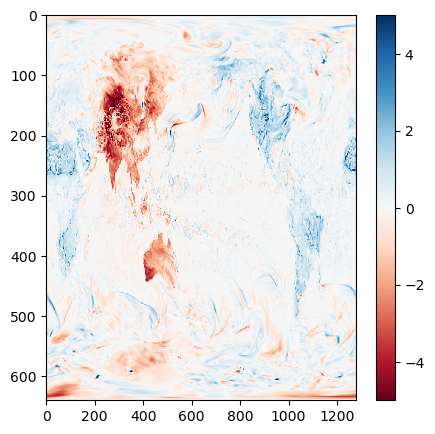

In [405]:
plt.pcolor(batch['historical_ERA5_images'][0,0,44,:,:]-batch['target_ERA5_images'][0,1,44,:,:],cmap='RdBu',vmin=-5,vmax=5)
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

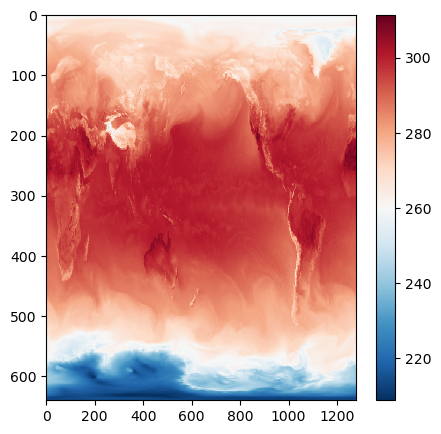

In [401]:
plt.pcolor(batch['historical_ERA5_images'][0,0,44,:,:],cmap='RdBu_r')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

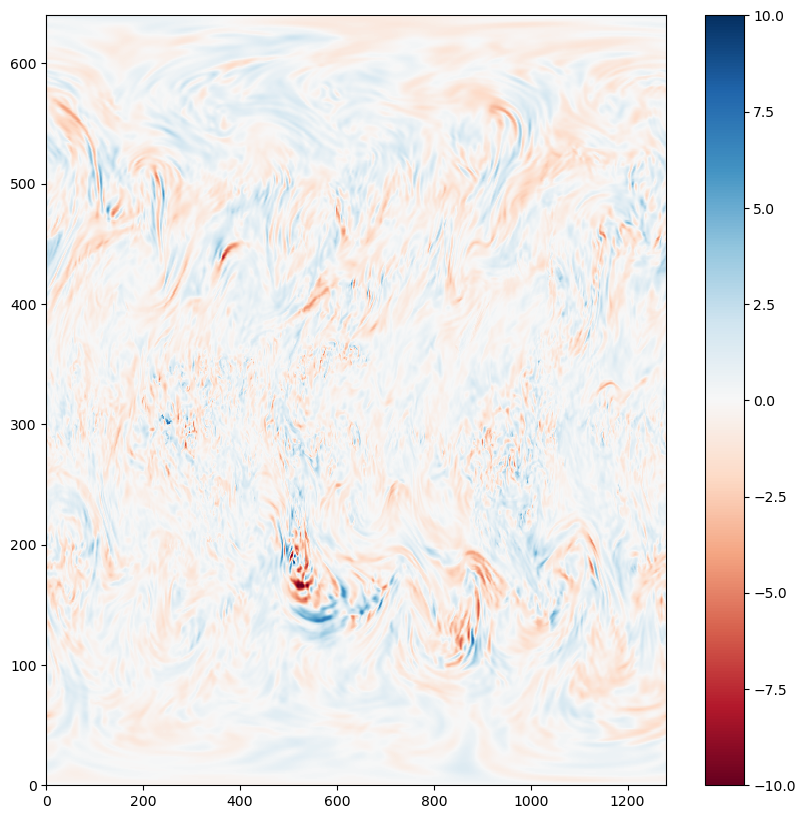

In [109]:
plt.pcolor(batch['target_ERA5_images'][0,0,5,:,:]-batch['historical_ERA5_images'][0,0,5,:,:],cmap='RdBu',vmin=-10,vmax=10)
plt.colorbar()

In [ ]:
numcodecs